Number of filtered glasses: 2
Number of glasses used for clustering: 241


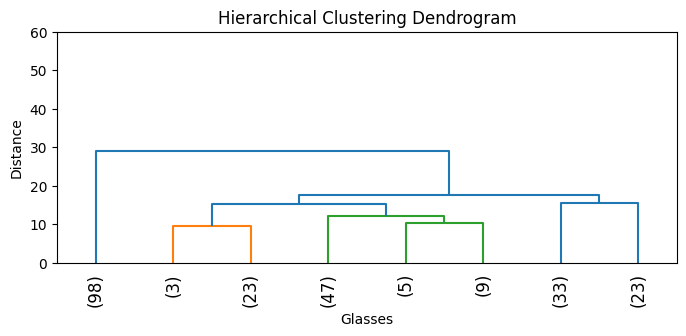

cluster
1    98
2    87
3    33
4    23
Name: dispense_cluster_count, dtype: int64


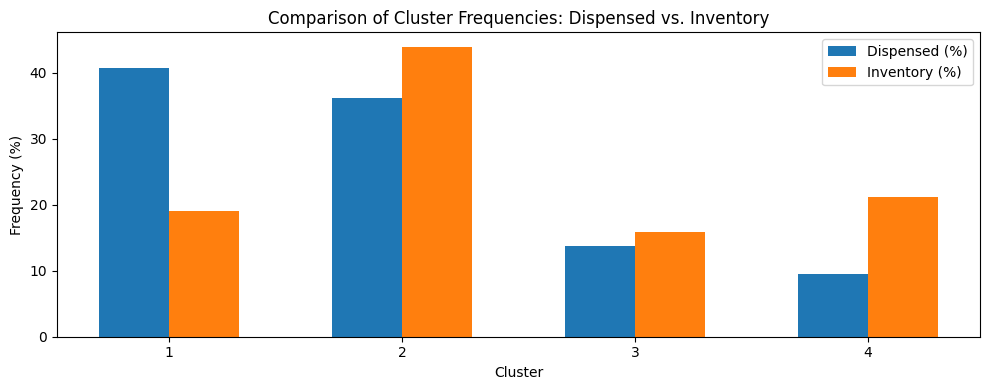

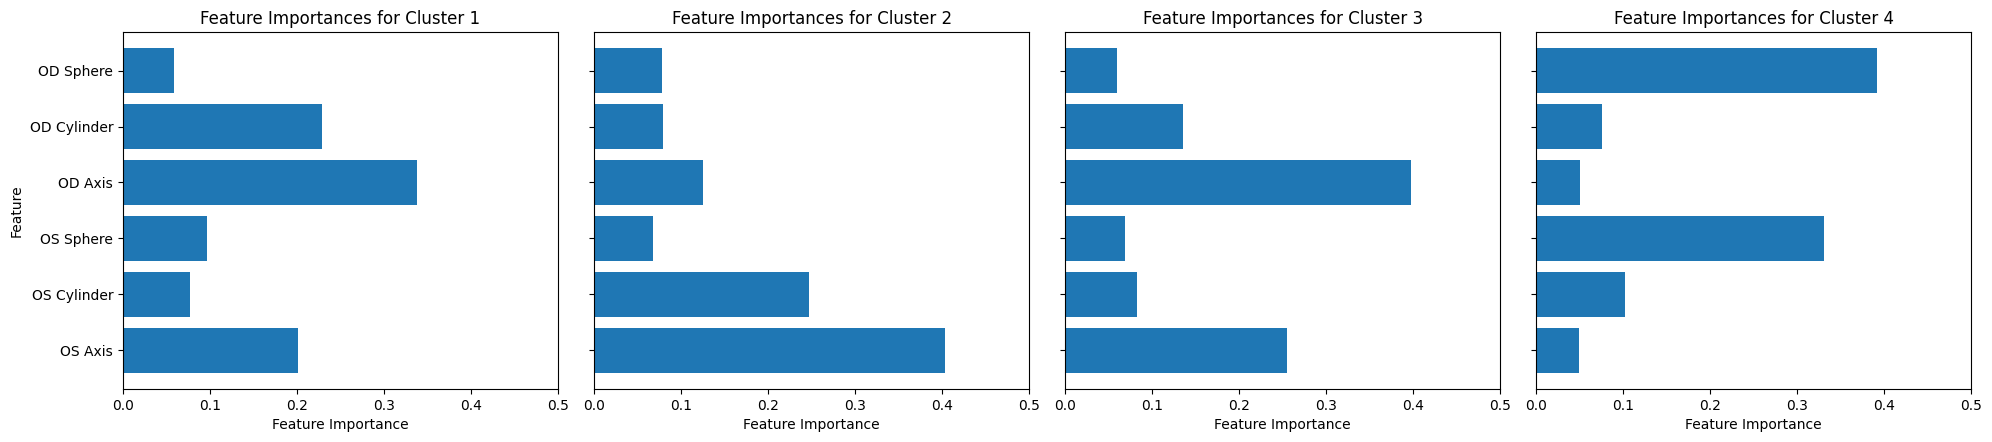

In [1]:
from analysis import launch
launch(False, 'sa', 4)

Number of filtered glasses: 4
Number of glasses used for clustering: 201


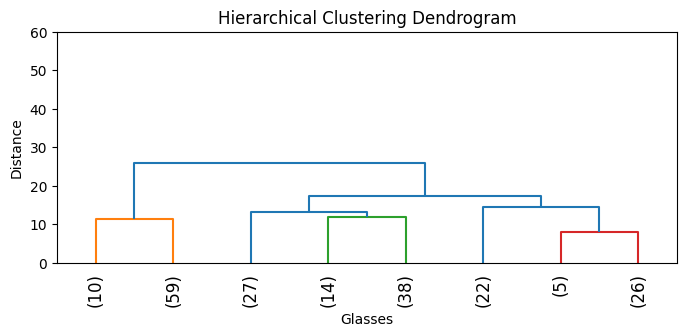

cluster
1    69
2    79
3    22
4    31
Name: dispense_cluster_count, dtype: int64


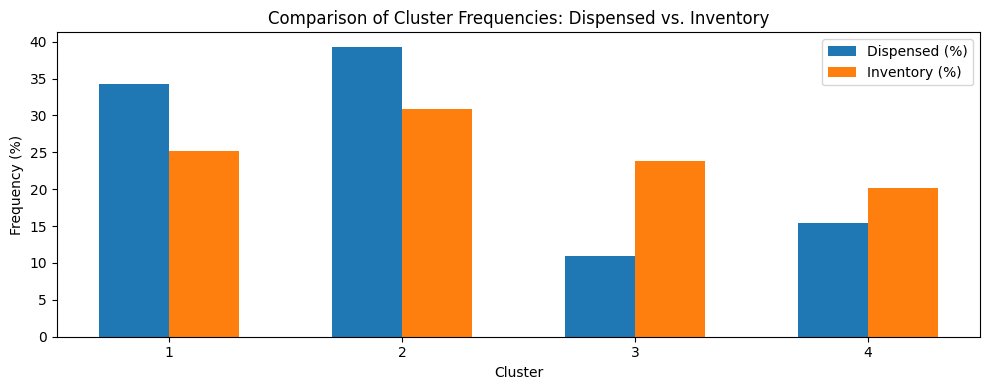

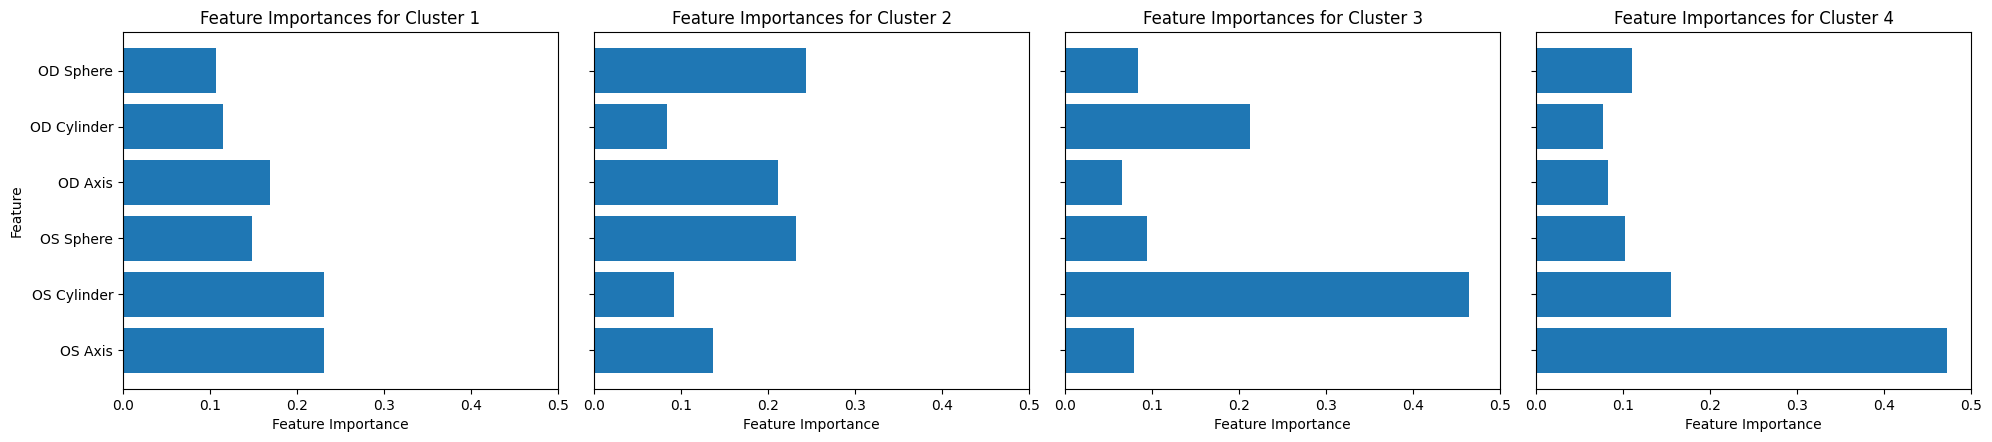

In [2]:
from analysis import launch
launch(False, 'sm', 4)

Number of filtered glasses: 12
Number of glasses used for clustering: 1054


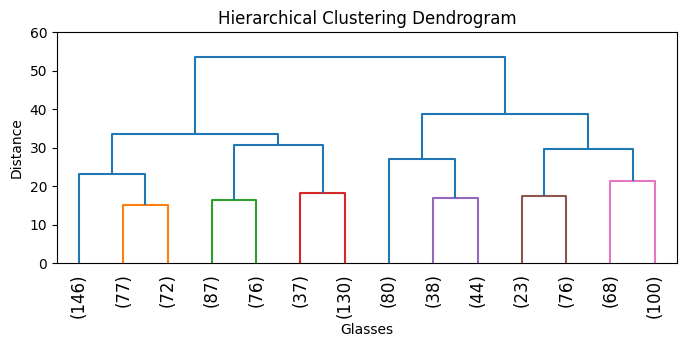

cluster
1    295
2    163
3    167
4     80
5     82
6     99
7    168
Name: dispense_cluster_count, dtype: int64


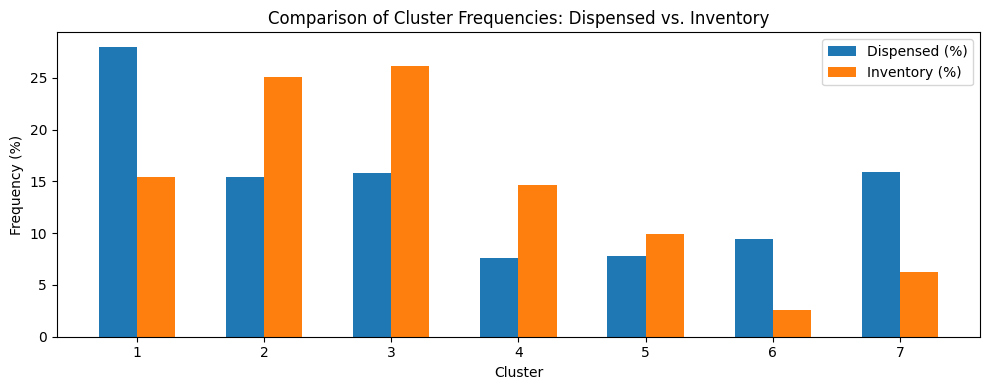

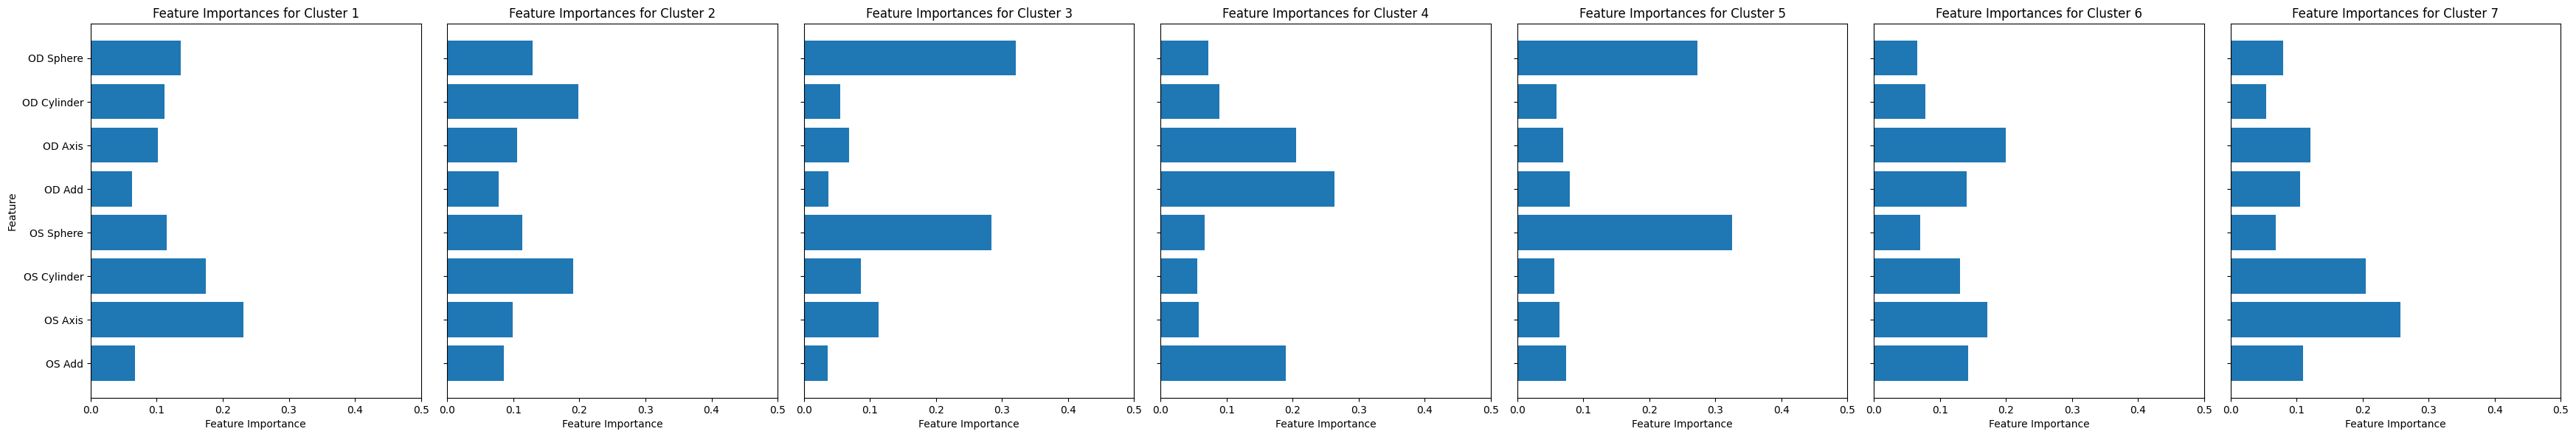

In [3]:
from analysis import launch
launch(True, 'sa', 7)

Number of filtered glasses: 8
Number of glasses used for clustering: 969


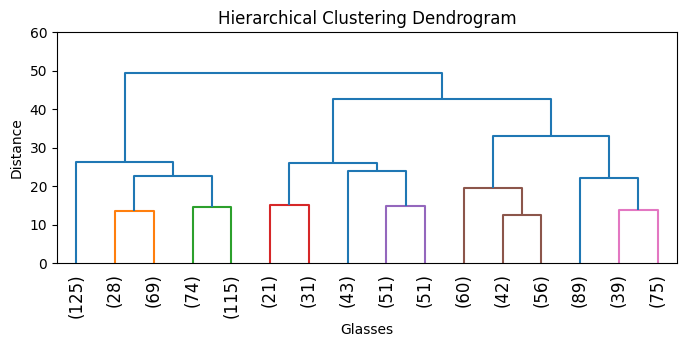

cluster
1    125
2     97
3    189
4     52
5     43
6    102
7    158
8    203
Name: dispense_cluster_count, dtype: int64


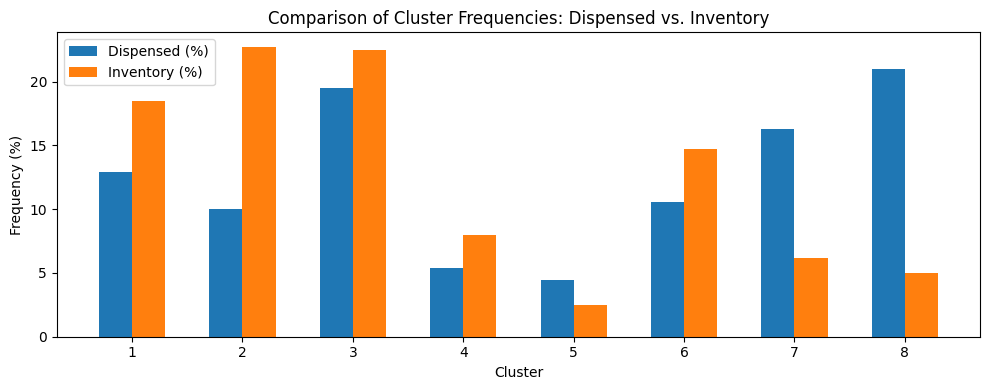

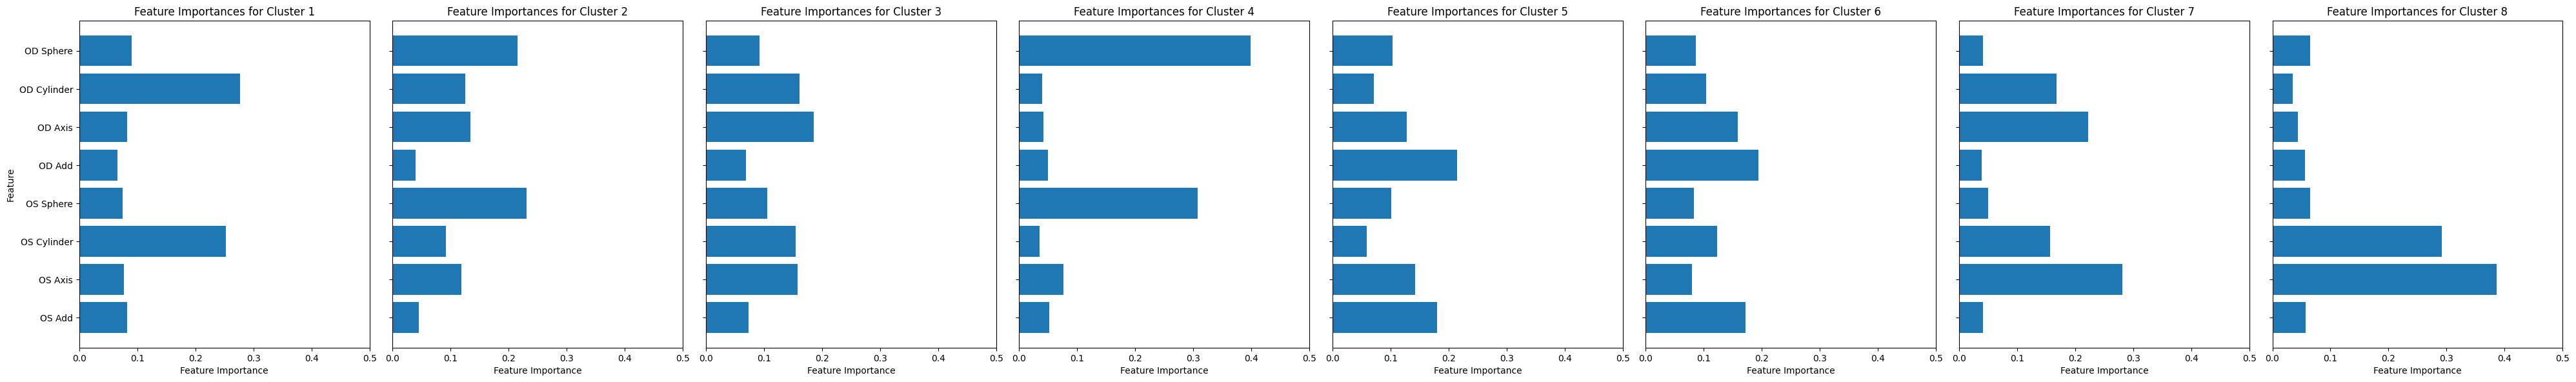

In [4]:
from analysis import launch
launch(True, 'sm', 8)